<a href="https://colab.research.google.com/github/DAbbottPersonal/Hydrostasis/blob/main/Hydrostasis_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing Template

## Importing the libraries

In [338]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

Initial setup of "drive" so I can grab the input files.

In [339]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset.

In [320]:
dataset = pd.read_csv('/content/assignment_data.csv')


In [340]:
print(dataset.head())
print(type(dataset.iloc[0,0]))

            timestamp  userid  sessionid  ... eventtype eventvalue  eventnote
2 2020-08-04 13:36:31      96       1541  ...       NaN        NaN        NaN
3 2020-08-04 13:36:36      96       1541  ...       NaN        NaN        NaN
4 2020-08-04 13:36:41      96       1541  ...       NaN        NaN        NaN
5 2020-08-04 13:36:46      96       1541  ...       NaN        NaN        NaN
6 2020-08-04 13:36:51      96       1541  ...       NaN        NaN        NaN

[5 rows x 12 columns]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Notice how the timestamp is of type string. This will be handled shortly.

# Preprocess our data

The data contains some blank spaces, NAN's, categorical variables, and scale differences. We should address this before doing any analysis.


In [341]:
dataset = dataset.dropna(how='any',subset=['hb','hbo','lip','h2o'])

I do simple data cleaning to turn the time (of type string) into a timestamp.

In [323]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])


We need to remove the first ten minutes of data, where there is a turn-on curve as the person's body adjusts the apparatus.

In [342]:
df = None
sessions = np.unique(dataset['sessionid'])
for session in sessions:
  if df is None:
    df = dataset[dataset['sessionid']==session].iloc[120:,]
  else:
    df = np.concatenate((df,dataset[dataset['sessionid']==session].iloc[120:,]),axis=0)
print(len(df))
print(len(dataset))

55306
61306


We lose about 10% of events from this, as expected.

Separate our variables and features as X and y respectively.

In [325]:
X = df[:, [0,1,2,4,5,6,7,8]]
y = df[:, 3]

We need to encode the sensor location. There should be an inserted column for left bicep, right bicep and forearm as [1 0 0], [0 1 0], and [0 0 1] respectively.

In [326]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

Then encode the control and hydration events as 0 and 1 respectively.

In [327]:
from sklearn.preprocessing import LabelEncoder
lc = LabelEncoder()
y = np.array(lc.fit_transform(y))

To check that it worked right print the dummy variables and unique values.

In [328]:
print(np.unique(y))
print(X[:,0:3])
print(X[0,])

[0 1]
[[1.0 0.0 0.0]
 [1.0 0.0 0.0]
 [1.0 0.0 0.0]
 ...
 [1.0 0.0 0.0]
 [1.0 0.0 0.0]
 [1.0 0.0 0.0]]
[1.0 0.0 0.0 Timestamp('2020-08-04 13:46:31') 96 1541 0.43799999999999994
 1.567 1.48 0.355]


## Splitting the dataset into the Training set and Test set

With some forethought, we want to split up the pool of events into a training set and testing set. This way, we save some unadultered events for later analysis. This will be made up of 20% of the total events.

In [329]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Examining our features

How do our features look in hydration events vs control events? This will give some broad insight as to which variables might be most meaningful to us. Therefore, we need should take a look at some plots.

In [330]:
combined = np.append(X, np.vstack(y), axis=1)
control = combined[combined[:,-1]==0]
signal = combined[combined[:,-1]==1]
variables = ['hb', 'hbo', 'lip', 'h2o']
var_dict = {'hb':6, 'hbo':7, 'lip':8, 'h2o':9}
arms = ['right', 'left', 'forearm']
arm_dict = {'right':[1, 0, 0],
            'left':[0, 1, 0],
            'forearm':[0, 0, 1]}
print(control[0])
print(type(control[0,3]))

[1.0 0.0 0.0 Timestamp('2020-08-04 13:46:31') 96 1541 0.43799999999999994
 1.567 1.48 0.355 0]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


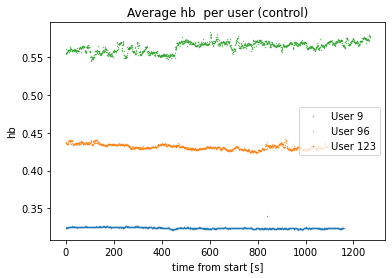

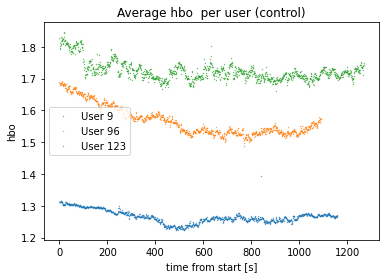

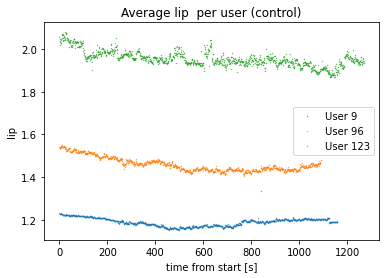

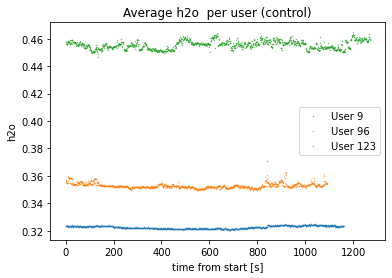

In [331]:
import matplotlib.pyplot as plt
import seaborn as sns
sessions = np.unique(control[:,5])
users = np.unique(control[:,4])
plots = {}
user_plots = {}
control_plots = {}
for cur_var in variables:
  plots[cur_var] = {}
  user_plots[cur_var] = {}
  control_plots[cur_var] = {}
  for session in sessions:
    session_series = control[control[:,5]==session]
    time_progression = np.vstack(range(0,len(session_series)))
    all_series[session] = session_series
    if session_series[0,4] in user_plots[cur_var]:
      user_plots[cur_var][session_series[0,4]].append(session_series[:,var_dict[cur_var]])
    else:
      user_plots[cur_var][session_series[0,4]] = []
      user_plots[cur_var][session_series[0,4]].append(session_series[:,var_dict[cur_var]])
    # uncomment to plot everything
    #plt.scatter(time_progression, session_series[:,var_dict[cur_var]], s=0.1)
  #plt.gca().set(title=' '.join(['Average',cur_var,' per user (control)']), xlabel="time from start [s]", ylabel=cur_var)
  #plt.show()
  for user in users:
    # user 6 has no hydration data. Skip for now.
    if user == 6:
      continue
    min = 999999
    for cur_arr in user_plots[cur_var][user]:
      if len(cur_arr) < min:
        min = len(cur_arr)
    summation = [0]*min
    for cur_arr in user_plots[cur_var][user]:
      for i in range(0,min):
        summation[i]+=(cur_arr[i]/len(user_plots[cur_var][user]))
    plt.scatter(np.vstack(range(0,min)), summation, s=0.1, label=('User ' + str(user)))
    control_plots[cur_var][user] = summation
  plt.legend()
  plt.gca().set(title=' '.join(['Average',cur_var,' per user (control)']), xlabel="time from start [s]", ylabel=cur_var)
  plt.show()


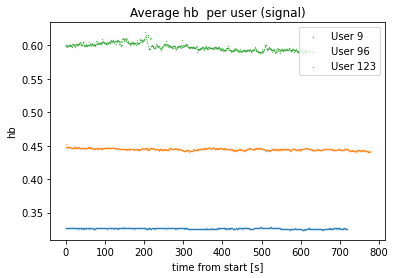

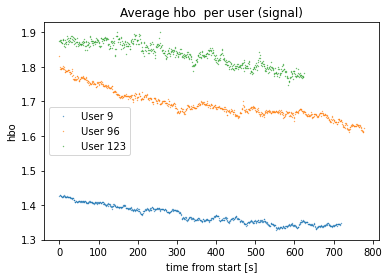

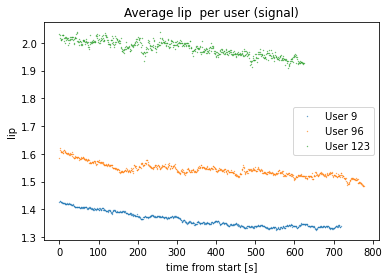

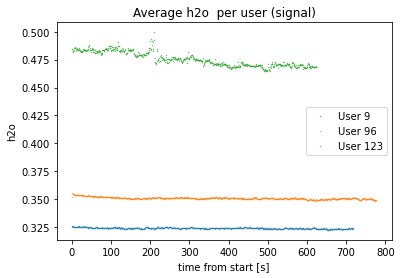

In [332]:
sessions = np.unique(signal[:,5])
users = np.unique(signal[:,4])
plots = {}
user_plots = {}
signal_plots = {}
for cur_var in variables:
  plots[cur_var] = {}
  user_plots[cur_var] = {}
  signal_plots[cur_var] = {}
  for session in sessions:
    session_series = signal[signal[:,5]==session]
    time_progression = np.vstack(range(0,len(session_series)))
    all_series[session] = session_series
    if session_series[0,4] in user_plots[cur_var]:
      user_plots[cur_var][session_series[0,4]].append(session_series[:,var_dict[cur_var]])
    else:
      user_plots[cur_var][session_series[0,4]] = []
      user_plots[cur_var][session_series[0,4]].append(session_series[:,var_dict[cur_var]])
    # uncomment to plot everything
    #plt.scatter(time_progression, session_series[:,var_dict[cur_var]], s=0.1)
  #plt.show()
  for user in users:
    min = 999999
    for cur_arr in user_plots[cur_var][user]:
      if len(cur_arr) < min:
        min = len(cur_arr)
    summation = [0]*min
    for cur_arr in user_plots[cur_var][user]:
      for i in range(0,min):
        summation[i]+=(cur_arr[i]/len(user_plots[cur_var][user]))
    plt.scatter(np.vstack(range(0,min)), summation, s=0.1, label=('User ' + str(user)))
    signal_plots[cur_var][user] = summation
  plt.legend()
  plt.gca().set(title=' '.join(['Average',cur_var,' per user (signal)']), xlabel="time from start [s]", ylabel=cur_var)
  plt.show()

Compare the control and signal plots directly next to each other for each variable. Remember to remove the first ten minutes from the final plots!

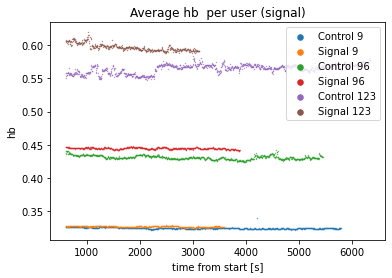

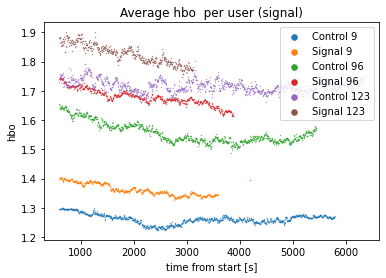

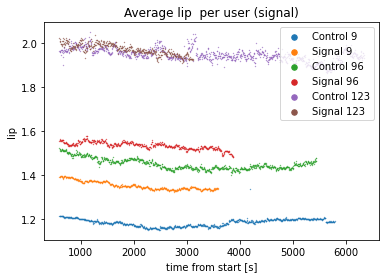

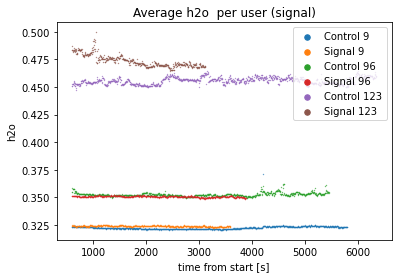

In [333]:
buffer_time = 600 #ten minutes

for cur_var in variables:
  for user in users:
    plt.scatter(np.vstack(range(600,600+5*len(control_plots[cur_var][user][120:]),5)), control_plots[cur_var][user][120:], s=0.1, label=('Control ' + str(user)))
    plt.scatter(np.vstack(range(600,600+5*len(signal_plots[cur_var][user][120:]),5)), signal_plots[cur_var][user][120:], s=0.1, label=('Signal ' + str(user)))
  lgnd = plt.legend(loc="upper right", scatterpoints=1)
  for l in range(0,6):
    lgnd.legendHandles[l]._sizes = [30]
  plt.gca().set(title=' '.join(['Average',cur_var,' per user (signal)']), xlabel='time from start [s]', ylabel=cur_var)
  plt.show()


Ultimately, it looks like we see some pretty big differences between control and signal for several of the variables. 

# Regression

Now we know how the features behave when comparing hydration events to control events. Let's perform some fits and quantize these effects.

In [334]:

X_train_clean = X_train[:,[0,1,2,4,5,6,7,8,9]]
X_test_clean = X_test[:,[0,1,2,4,5,6,7,8,9]]
print(X_train_clean[1,:])
features = ['is_right_bic','is_left_bic','is_forearm','user','session','hb','hbo','lip','h2o']

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
reg = regressor.fit(X_train_clean, y_train)
np.set_printoptions(precision=4)
print(reg.coef_)
print(reg.intercept_)

[1.0 0.0 0.0 96 1895 0.43 1.393 1.183 0.35100000000000003]
[ 0.1287 -0.2455  0.1168 -0.0024  0.0008  0.7195  0.379   0.2291 -0.1302]
-2.3418565736974024


# Prediction

We can test our quantization of the aforementioned trends in the features by applying it to the "test" data that we set aside earlier in the notebook.

In [335]:
from sklearn.metrics import mean_absolute_error
y_pred = regressor.predict(X_test_clean)
np.set_printoptions(precision=0)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[0:10,:])


wrong = 0
for i in range(0,len(y_pred)):
  y_pred_interpretted = 1
  if y_pred[i] < 0.5:
    y_pred_interpretted = 0
#  if abs(y_pred[i]) != abs(y_test[i]):
  if abs(y_pred_interpretted) != abs(y_test[i]):
    wrong+=1
success_rate = (1.*len(y_pred)-wrong)/len(y_pred)
print(str(success_rate))
#print(mean_absolute_error(y_test, y_pred))

[[ 1.  1.]
 [ 0.  1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1.  1.]
 [-0.  0.]
 [ 0.  0.]
 [-0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
0.7545651780871452


How "important" is each variable in determining the outcome, according to the linear regression?

In [336]:
!pip install eli5

In [337]:
import eli5
from eli5.sklearn import PermutationImportance
#perm = PermutationImportance(regressor, random_state=0).fit(y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1))
perm = PermutationImportance(regressor, random_state=0).fit(X_test_clean, y_test.reshape(len(y_test),1))
print(eli5.format_as_text(eli5.explain_weights(perm, feature_names=features)))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.3443 ± 0.0159  session
0.1133 ± 0.0073  user
0.0889 ± 0.0054  hbo
0.0651 ± 0.0022  is_left_bic
0.0472 ± 0.0028  hb
0.0467 ± 0.0050  lip
0.0286 ± 0.0040  is_right_bic
0.0118 ± 0.0028  is_forearm
0.0007 ± 0.0007  h2o
